In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

data_folder = 'data'

Load data from parquet file

In [20]:
df = pd.read_parquet("tripdata_combined.parquet")

Preprocessing

In [21]:
# Keep relevant columns for regression
df = df[["trip_distance", "PULocationID", "passenger_count", "payment_type", "tip_amount", "time_of_day", "day_of_week", "season"]]

# Convert tip amount to whether or not customers tipped - consider tips lower than 25 cents as no tip
y =  (df['tip_amount'] > 0.25).astype(int).values

Setup model pipeline

In [22]:
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# One-hot encode categorical features and scale numerical features
preprocessor = ColumnTransformer([
    ('num', num_transformer, ['trip_distance']),
    ('cat', cat_transformer, ['passenger_count', 'PULocationID', 'payment_type', 'time_of_day', 'day_of_week', 'season']),
])

# Create linear regression model pipeline
logreg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegressionCV(Cs=10, cv=5, scoring='accuracy', max_iter=1000, random_state=42))
])

# knn_model = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', KNeighborsClassifier())
# ])

tree_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=1, n_jobs=-1))
])

# Decision Tree
# dt_model = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', DecisionTreeClassifier(random_state=42))
# ])

# Gradient Boosting
gb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

# SVM
svm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
])

# Naive Bayes
nb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

# Neural Network
nn_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), random_state=42))
])

# XGBoost
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, random_state=42))
])

Perform train-test split and train models

In [23]:
X = df.drop('tip_amount', axis=1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# logreg_model.fit(X_train, y_train)
# print("Logistic Regression model done training")

# knn_model.fit(X_train, y_train)
# print("KNN model done training")

# tree_model.fit(X_train, y_train)
# print("Random Forest model done training")

In [ ]:
# dt_model.fit(X_train, y_train)
# print("Decision Tree model done training")

gb_model.fit(X_train, y_train)
print("Gradient boost model done training")

Gradient boost model done training


In [26]:
# nb_model.fit(X_train.to_array(), y_train)
# print("Naive Bayes model done training")

nn_model.fit(X_train, y_train)
print("MLP model done training")

xgb_model.fit(X_train, y_train)
print("XGBoost model done training")

MLP model done training
XGBoost model done training


In [ ]:
svm_model.fit(X_train, y_train)
print("SVM model done training")

In [ ]:
# logreg_model.fit(X_train, y_train)
# print("Logistic Regression model done training")

Save the Models

In [ ]:
# with open("alex_rq1_model_logreg.pkl", "wb") as file:
#     pickle.dump(logreg_model, file)
# with open("alex_rq1_model_knn.pkl", "wb") as file:
#     pickle.dump(knn_model, file)
# with open("alex_rq1_model_tree.pkl", "wb") as file:
#     pickle.dump(tree_model, file)

Load Pre-trained Models

In [27]:
with open("alex_rq1_model_logreg.pkl", "rb") as file:
    logreg_model = pickle.load(file)
# with open("alex_rq1_model_knn.pkl", "rb") as file:
#     knn_model = pickle.load(file)
with open("alex_rq1_model_tree.pkl", "rb") as file:
    tree_model = pickle.load(file)

Evaluate model

In [28]:
def eval(y_pred, y_test):
    acc = np.dot(y_pred, y_test) / y_test.size
    confmat = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = np.ravel(confmat)
    acc = (tp + tn) / y_test.size
    precision = tp / (tp + fp)
    recall = tp / (tp + fn) 

    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Confusion matrix:\n{confmat}")

    # Plot Confusion Matrix
    class_labels = ["No Tip", "Tip"]
    ax = sns.heatmap(confmat / np.sum(confmat), annot=True, fmt='.2%', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

    ax.xaxis.tick_top()
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

Accuracy: 0.9437486355249444
Precision: 0.9510838467961132
Recall: 0.974662177623104
Confusion matrix:
[[ 987177  169782]
 [  85817 3301096]]


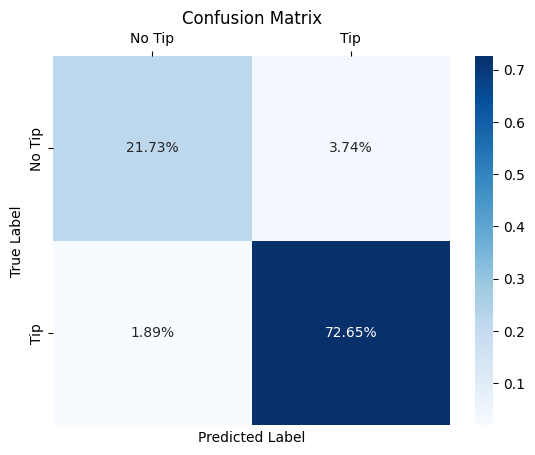

In [29]:
eval(logreg_model.predict(X_test), y_test)

Accuracy: 0.9227907388236288
Precision: 0.9418739360971328
Recall: 0.9553755883307307
Confusion matrix:
[[ 957269  199690]
 [ 151139 3235774]]


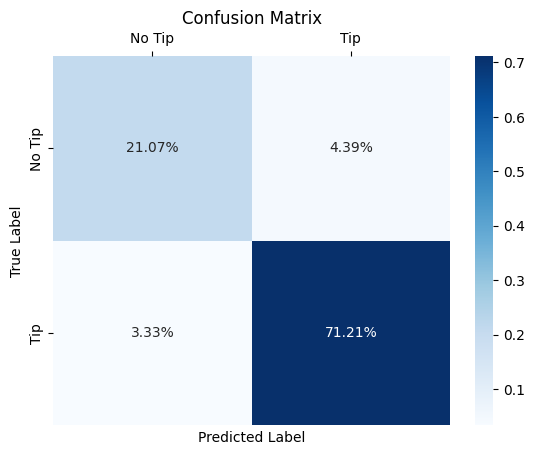

In [30]:
eval(tree_model.predict(X_test), y_test)

In [31]:
# eval(dt_model.predict(X_test), y_test)

Accuracy: 0.9411019940702555
Precision: 0.94622479184298
Recall: 0.9764771046672884
Confusion matrix:
[[ 969004  187955]
 [  79670 3307243]]


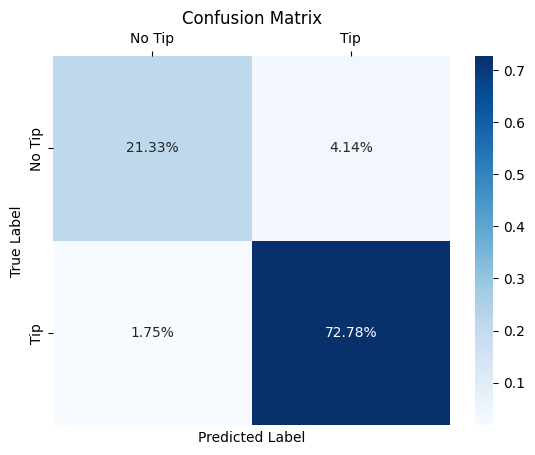

In [32]:
eval(gb_model.predict(X_test), y_test)

In [ ]:
# eval(svm_model.predict(X_test), y_test)

NotFittedError: Pipeline is not fitted yet.

Accuracy: 0.9437486355249444
Precision: 0.9510838467961132
Recall: 0.974662177623104
Confusion matrix:
[[ 987177  169782]
 [  85817 3301096]]


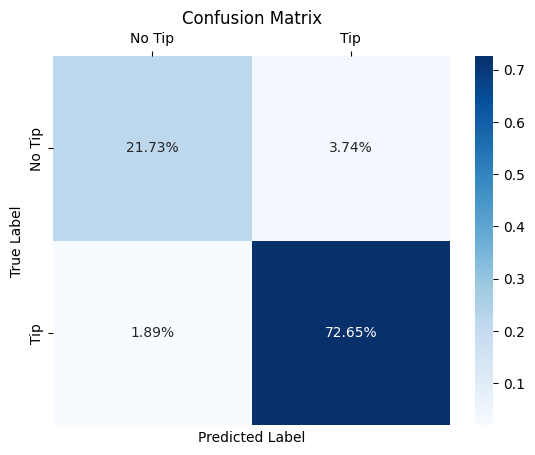

In [ ]:
eval(nb_model.predict(X_test), y_test)

Accuracy: 0.9437486355249444
Precision: 0.9510838467961132
Recall: 0.974662177623104
Confusion matrix:
[[ 987177  169782]
 [  85817 3301096]]


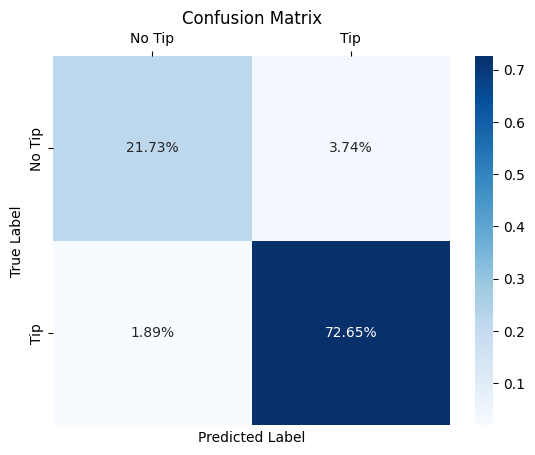

In [ ]:
eval(nn_model.predict(X_test), y_test)

Accuracy: 0.9437486355249444
Precision: 0.9510838467961132
Recall: 0.974662177623104
Confusion matrix:
[[ 987177  169782]
 [  85817 3301096]]


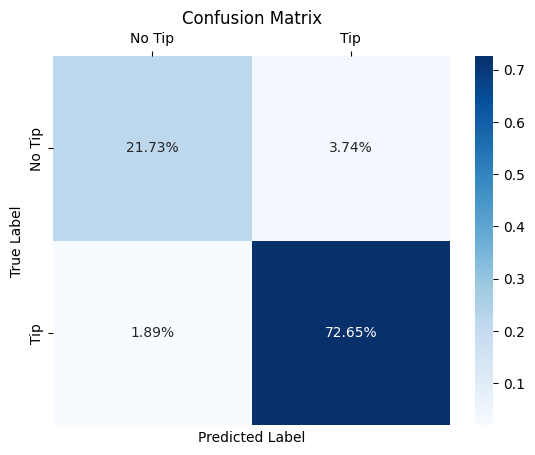

In [ ]:
eval(xgb_model.predict(X_test), y_test)

In [ ]:
# eval(knn_model.predict(X_test), y_test)

KeyboardInterrupt: 